# Introduction to Attention

Attention is a mechanism that helps models focus on important parts of an input.

Imagine a chatbot that processes the sentence: "The cat sat on the mat."; If we ask, "Where did the cat sit?", the chatbot should focus on the words "sat" and "mat" instead of other words.
Self-attention helps achieve this dynamically by computing relevance scores.


Mathematically, we want to map a Query (Q) and a set of Key (K) and Value (V) pairs to an output. or in simpler terms, we want to find the most relevant value (V) eg. "mat" given the query (Q) eg. "cat" and the key (K) eg. "sat".


## Step 1: Compute the relevance scores between the Query (Q) and the Key (K)


This is done by taking the dot product of the Query (Q) and the Key (K) because the dot product 
gives us a measure of similarity between two vectors.

Example:
If two vectors are pointing in the same direction, their dot product is large (high similarity).
If they are perpendicular, the dot product is small (low similarity).

Mathematically:

$$ scores = QK^T$$

Where:
- Q is the Query matrix
- K is the Key matrix
- T denotes the transpose operation

> Transpose operation is used to ensure that the dimensions of the matrices are compatible for multiplication.

Each element in the resulting matrix represents how much focus should be given
to a word when processing another word.


In [79]:
# import relevant packages
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from rich import print

In [80]:
def compute_attention_scores(Q, K):
    return np.dot(Q, K.T)  # Compute dot product


In [81]:

# Example to demonstrate dot product and similarity
cat = np.array([1, 2, 3])
dog = np.array([1, 3, 2]) # Similar to cat (animals, pets, mammals) (High Similarity)
table = np.array([-1, -2, -3]) # Very different from cat (objects, furniture) (Low Similarity)
sit = np.array([3, 2, 1]) # somewhat related to cat (actions, verbs) (Medium Similarity)

print("Dot Product Similarity Examples:")
print("cat · dog (High Similarity):", np.dot(cat, dog))
print("cat · table (Opposite Direction - Low Similarity):", np.dot(cat, table))
print("cat · sit (Different Direction - Medium Similarity):", np.dot(cat, sit))



Dot Product Similarity Examples:

cat · dog (High Similarity): 13

cat · table (Opposite Direction - Low Similarity): -14

cat · sit (Different Direction - Medium Similarity): 10

In [82]:
word_vectors = np.array([cat, dog, table, sit])
words = ['cat', 'dog', 'table', 'sit']

In [83]:
scores_unscaled = compute_attention_scores(word_vectors, word_vectors)


print(f"Dot Product Similarity Matrix: \n{scores_unscaled}")


Dot Product Similarity Matrix: 
[[ 14  13 -14  10]
 [ 13  14 -13  11]
 [-14 -13  14 -10]
 [ 10  11 -10  14]]

# Step 1.1: Apply Scaling to the Scores

One issue with dot product attention is that as the vector size (d_k) increases,
the values in the dot product become large, leading to extreme softmax outputs (output from the next step).
This can cause small gradients, making training unstable.

To prevent this, we scale the attention scores by multiplying by the inverse square root of the dimension of the Key vector (d_k).

Mathematically:

$$ scores = QK^T * \frac{1}{\sqrt{d_k}}$$


This keeps the values in a reasonable range before applying softmax.

In [84]:
def compute_scaled_attention_scores(Q, K, d_k):
    # return np.dot(Q, K.T) / np.sqrt(d_k)  # Apply scaling factor
    return np.dot(Q, K.T) * (1/np.sqrt(d_k))  # Apply scaling factor


In [85]:
scaled_scores = compute_scaled_attention_scores(word_vectors, word_vectors, d_k=3)
print(f"unscaled attention scores: \n{scores_unscaled}")


print(f"Scaled Attention Scores: \n{scaled_scores}")



unscaled attention scores: 
[[ 14  13 -14  10]
 [ 13  14 -13  11]
 [-14 -13  14 -10]
 [ 10  11 -10  14]]

Scaled Attention Scores: 
[[ 8.08290377  7.5055535  -8.08290377  5.77350269]
 [ 7.5055535   8.08290377 -7.5055535   6.35085296]
 [-8.08290377 -7.5055535   8.08290377 -5.77350269]
 [ 5.77350269  6.35085296 -5.77350269  8.08290377]]

## step 2: Normalize the scores

Now that we have the relevance scores, we need to normalize them so that they are between 0 and 1.

> 0 means the word is not important, and 1 means the word is very important.

This is done using the softmax function, which squashes the scores between 0 and 1.

matheamtically:

$$ softmax(x_i) = \frac{e^{x_i}}{\sum_j e^{x_j}} $$

Where:
- e is the exponential function
- x_i is the raw score for a particular word (ie the i-th word)
- j is the total number of words
- the denominator is the sum of the exponential scores of all words and ensures that the scores sum to 1.


In [86]:
def softmax(attention_scores):
    """Compute softmax values for each row of attention_scores."""
    
    exp_x = np.exp(attention_scores - np.max(attention_scores))  # Subtract maximium value of x to prevent overflow
    return exp_x / np.sum(exp_x,axis=1, keepdims=True)  # Compute softmax values for each sets of scores in attention_scores


Softmax Scores:

[[6.02154003e-01 3.38039571e-01 5.74098707e-08 5.98063687e-02]
 [3.22948976e-01 5.75272943e-01 9.76996427e-08 1.01777983e-01]
 [9.53407269e-08 1.69831598e-07 9.99998775e-01 9.59927875e-07]
 [7.78227408e-02 1.38626596e-01 7.52152323e-07 7.83549912e-01]]

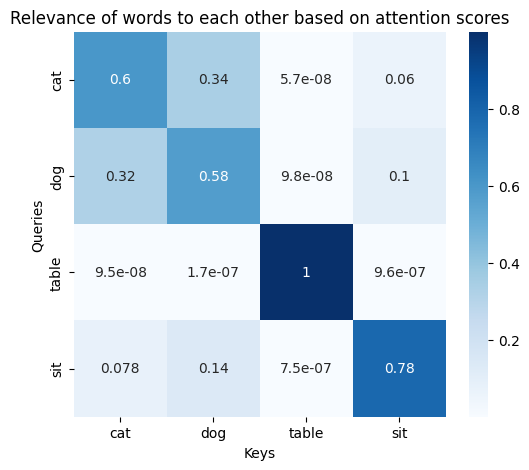

In [87]:
scores = scaled_scores
softmax_scores = softmax(scores)
print("\nSoftmax Scores:")
print(softmax_scores)


# Plot similarity grid
plt.figure(figsize=(6, 5))
sns.heatmap(softmax_scores, annot=True, cmap="Blues", xticklabels=words, yticklabels=words, cbar=True)
plt.xlabel("Keys")
plt.ylabel("Queries")
plt.title("Relevance of words to each other based on attention scores")
plt.show()

# Step 3: Compute the weighted sum of the values (V)


Now that we have the normalized attention scores, we need to use them to generate a meaningful representation.

Each word has an associated value vector (V). The attention scores tell us how much each word should contribute
to the final representation.

To compute the final representation for a word, we take a **weighted sum** of all value vectors (V),
where the weights are the attention scores.

matheamtically:

$$ output = attention\_weights * V $$

Where:

- attention_weights are the normalized attention scores
- V is the value matrix
- output is the final representation of the word
  
This step allows the model to dynamically highlight the most relevant parts of the input.
If a word is important, its value vector contributes more to the output.


In [88]:
def compute_weighted_sum(attention_weights, V):
    return np.dot(attention_weights, V)  # Weighted sum of values

In [89]:
value_vectors = np.array([
    [0.2, 0.8, 0.6],  # "cat"
    [0.3, 0.7, 0.5],  # "dog"
    [0.9, 0.1, 0.3],  # "table"
    [0.4, 0.5, 0.9]   # "sit"
])

weighted_output = compute_weighted_sum(softmax_scores, value_vectors)
print("\nWeighted Sum Output (Final Word Representations):")
print(weighted_output)


Weighted Sum Output (Final Word Representations):

[[0.24576527 0.74825409 0.58413794]
 [0.27788296 0.71193924 0.57300607]
 [0.89999935 0.10000055 0.30000064]
 [0.37057317 0.55107184 0.82120209]]

# Step 4: Putting it all together


Now, we bring all the steps together to compute the final self-attention output.

In our chatbot example, each word in a sentence (Q) looks for relevant context (K) to form a better representation (V).
We generate random embeddings to simulate a sentence where each word is represented as a vector.

$$ Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}}) V $$

Where:

In [90]:
def scaled_dot_product_attention(Q, K, V, d_k):
    scores = compute_scaled_attention_scores(Q, K, d_k)  # Step 1: Calculate attention scores
    attention_weights = softmax(scores)  # Step 2: Normalize scores
    output = compute_weighted_sum(attention_weights, V)  # Step 3: Compute weighted sum
    return output, attention_weights


In [91]:
# Example scenario: Processing a sentence with self-attention
np.random.seed(43)  # For reproducibility

d_k = 4  # Dimension of key/query/value vectors
num_words = 4  # Using "cat", "dog", "table", "sit"

# Simulating random embeddings for the words in our example
Q = np.random.randn(num_words, d_k)
K = np.random.randn(num_words, d_k)
V = np.random.randn(num_words, d_k)

# Compute self-attention manually
output, attention_weights = scaled_dot_product_attention(Q, K, V, d_k)

print("\nAttention Weights (Relevance of words to each other):")
print(attention_weights)
print("\nFinal Word Representations After Attention:")
print(output)



Attention Weights (Relevance of words to each other):

[[0.55163714 0.16507099 0.12447132 0.15882055]
 [0.16208543 0.2395443  0.28640226 0.31196801]
 [0.53772785 0.09163498 0.1392443  0.23139287]
 [0.06966257 0.61796892 0.20167231 0.11069621]]

Final Word Representations After Attention:

[[-0.35667894  0.3682607  -0.32647041  1.59660508]
 [-0.34862564  0.47489483 -0.19276363  1.57285549]
 [-0.22956324  0.23570726 -0.3065945   1.56186642]
 [-1.09423218  1.01812449 -0.352135    1.61989783]]

The final output of attention is a new set of word representations, computed as a weighted sum of the Value (V) vectors.
These updated representations capture **contextual meaning**—a word now carries information about other related words.

However, this transformation happens in **high-dimensional space**, making it difficult to visualize directly.
One way to approximate these changes is by reducing the dimensions (e.g., PCA, t-SNE), but for now let's focus on the core concepts of attention.

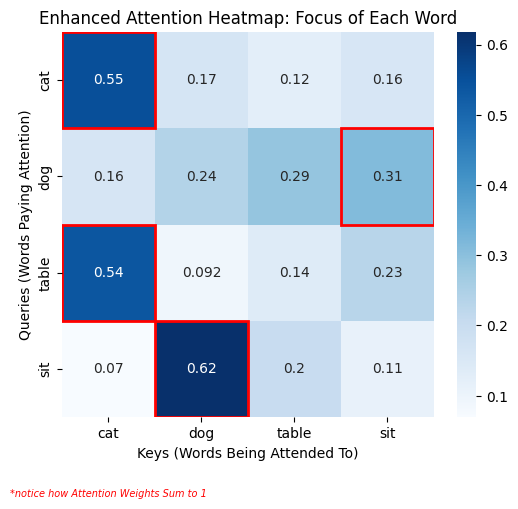

In [117]:

plt.figure(figsize=(6, 5))
ax = sns.heatmap(attention_weights, annot=True, cmap="Blues", xticklabels=words, yticklabels=words, cbar=True)

# Highlight the max value per row (strongest attention)
for i in range(attention_weights.shape[0]):
    max_index = np.argmax(attention_weights[i])
    ax.add_patch(plt.Rectangle((max_index, i), 1, 1, fill=False, edgecolor='red', lw=2))

# notice how  the sum of each row is 1
plt.text(0.5, 4.8, "*notice how Attention Weights Sum to 1", ha='center', va='center', fontsize=7, color='red', fontstyle='italic')

plt.xlabel("Keys (Words Being Attended To)")
plt.ylabel("Queries (Words Paying Attention)")
plt.title("Enhanced Attention Heatmap: Focus of Each Word")
plt.show()


<!-- 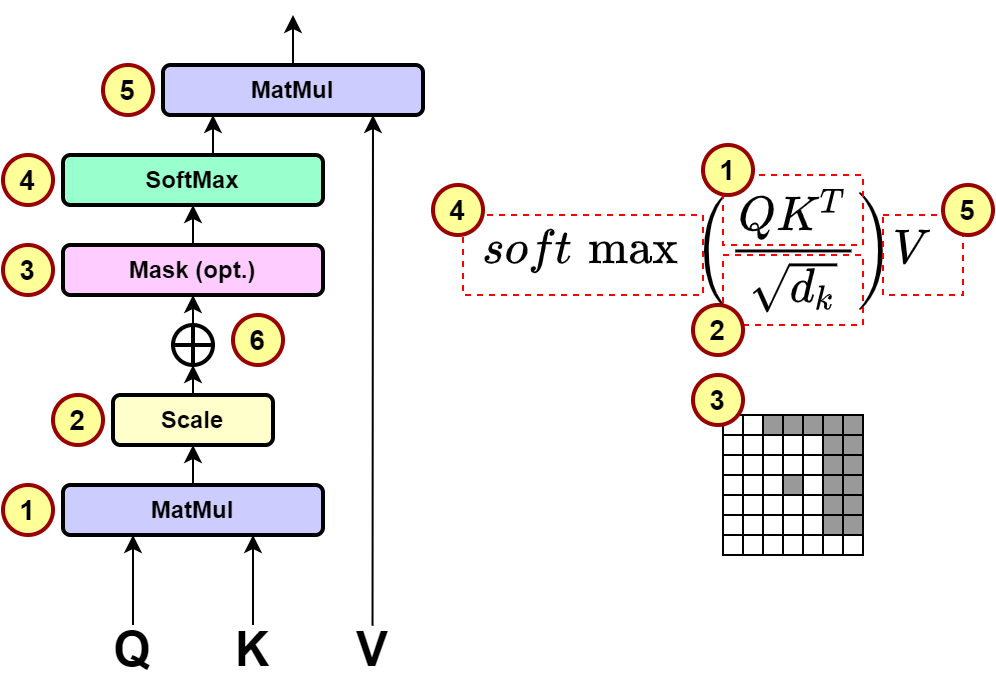 -->
# Summary

**Query (Q)**: Represents the current word to find the most relevant words in the sentence.
**Key (K)**: Represents the words in the sentence that are compared with the Query to generate relevance scores.
**Value (V)**: Represents the words in the sentence that contribute to the final representation of the Query.

**you compare the ‘query’ with the ‘keys’ and get scores/weights for the ‘values.’,**

**Each score/weight is the relevance between the ‘query’ and each ‘key’.**

**reweight the ‘values’ with the scores/weights, and take the summation of the reweighted ‘values’.”**

<img src="1_ScaledDotAttention.png" alt="Scaled Dot Attention" style="display: block; margin-left: auto; margin-right: auto; width: 50%;">

*image source: https://wikidocs.net/167211*



Scaled Dot-Product Attention:

**1**: Compute the Relevance Scores between the Query and Key using the dot product *(MatMul)*. given by: $scores = QK^T$

**2**: *Scale* the Scores by dividing by the square root of the Key dimension. given by: $scores = QK^T * \frac{1}{\sqrt{d_k}}$
> 
>**3** Optional: Masking in Attention (Why We Haven't Included It Yet)
>In some scenarios, we need to **mask** certain parts of the attention scores:
>1. **Padding Mask**: Used to ignore padding tokens in a sentence (common in batch processing).
>2. **Causal Mask (Look-Ahead Mask)**: Used in decoder self-attention to prevent attending to future words.

>Since this notebook focuses on self-attention in its simplest form (as used in encoders), masking isn't strictly necessary.
>However, in the next notebook on **Multi-Head Attention**, we will introduce masking when dealing with more complex attention mechanisms.

**4**: Normalize the Scores using the *Softmax* function to get the Attention Weights.

**5**: Compute the weighted sum of the Values using the Attention Weights. given by: $output = attention\_weights * V $







At this stage weve seen how self attention dynamically determines the relevance of words in a sentence to each other. The attention weights show how much focus each word should place on another, and the final word representations (output vectors) are weighted combinations of the values (V), which encode contextual meaning.

However, there is still one limitation:

Our attention mechanism is operating in a single representation space. But in reality, words can have multiple nuanced relationships. For example, in "The cat sat on the mat," "cat" might be related to "mat" spatially, but also to "sat" in terms of action.

This is where Multi-Head Attention comes in! Instead of computing a single set of attention scores, we compute multiple sets (heads), each capturing different aspects of meaning.

In the next notebook, we'll explore how Multi-Head Attention enhances self-attention by allowing the model to attend to multiple representations simultaneously.